# Modelling

In [21]:
import warnings
import numpy as np
import pandas as pd
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score


In [11]:
rental_df_selected_train = pd.read_csv('../data/rental_df_selected_train.csv')
rental_df_selected_test = pd.read_csv('../data/rental_df_selected_test.csv')

## Base Model 1 - SVM

In [ ]:
# Prepare the datasets
X_train = rental_df_selected_train.drop(columns=['rent'])
y_train = rental_df_selected_train['rent']
X_test = rental_df_selected_test.drop(columns=['rent'])
y_test = rental_df_selected_test['rent']

best_r2_train_scores = []
best_r2_test_scores = []
mean_squared_errors_train = []
mean_squared_errors_test = []
titles = []

# Define the SVR models and their titles
models = [
    svm.SVR(kernel='linear'),
    svm.SVR(kernel='rbf'),
    svm.SVR(kernel='poly')
]

model_titles = [
    'SVR with linear kernel',
    'SVR with RBF kernel',
    'SVR with polynomial kernel'
]

# Define the reduced grid search parameter grids
param_grid_linear = {'svr__C': [0.1, 1, 10]}
param_grid_rbf = {
    'svr__C': [0.1, 1, 10],  # Reduced range for C
    'svr__gamma': [0.1, 1]   # Reduced range for gamma
}
param_grid_poly = {
    'svr__C': [0.1, 1, 10],  # Reduced range for C
    'svr__gamma': [0.1],     # Reduced range for gamma
    'svr__degree': [2, 3]    # Reduced range for degree
}

# Combine parameter grids with their respective models
param_grids = [param_grid_linear, param_grid_rbf, param_grid_poly]

# Step 2: Perform GridSearchCV for each model
for title, model, param_grid in zip(model_titles, models, param_grids):
    
    pipeline_svm = Pipeline([
        ('scaler', StandardScaler()),  # Standardizing features
        ('svr', model)                 # SVR model
    ])

    grid_search_svm = GridSearchCV(pipeline_svm, param_grid, cv=5, scoring='r2')

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        grid_search_svm.fit(X_train, y_train)  # Use train data for fitting

    # Step 3: Store R² and MSE results for train
    best_r2_train = grid_search_svm.best_score_
    mse_scorer = make_scorer(mean_squared_error)
    train_mse = cross_val_score(grid_search_svm.best_estimator_, X_train, y_train, 
                                 cv=5, scoring=mse_scorer).mean()

    # Store test results
    test_r2_score = grid_search_svm.score(X_test, y_test)
    test_mse = mean_squared_error(y_test, grid_search_svm.predict(X_test))

    # Append results to lists
    best_r2_train_scores.append(best_r2_train)
    best_r2_test_scores.append(test_r2_score)
    mean_squared_errors_train.append(train_mse)
    mean_squared_errors_test.append(test_mse)
    titles.append(title)

    print(f"{title}: Best R² Score (Train)={best_r2_train:.4f}, MSE (Train)={train_mse:.4f}")
    print(f"Test R² Score={test_r2_score:.4f}, MSE (Test)={test_mse:.4f}")

# Step 7: Plot R² scores and MSE for both training and test sets together
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot R² scores on the train and test sets
color = 'tab:blue'
ax1.set_xlabel('SVR Model')
ax1.set_ylabel('R² Score', color=color)
ax1.bar(titles, best_r2_train_scores, color=color, alpha=0.6, label='Train R²')
ax1.bar(titles, best_r2_test_scores, color='tab:green', alpha=0.3, label='Test R²')
ax1.tick_params(axis='y', labelcolor=color)

# Create a twin axis to plot MSE for both train and test sets
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Mean Squared Error', color=color)
ax2.plot(titles, mean_squared_errors_train, color='tab:red', marker='o', linestyle='--', label='Train MSE')
ax2.plot(titles, mean_squared_errors_test, color='tab:purple', marker='s', linestyle='-', label='Test MSE')
ax2.tick_params(axis='y', labelcolor=color)

# Finalize the plot
fig.tight_layout()
plt.title('R² Score and Mean Squared Error (Train vs Test for SVM)')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)
plt.show()

SVR with linear kernel: Best R² Score (Train)=0.2801, MSE (Train)=24430.5301
Test R² Score=0.2486, MSE (Test)=26895.8224


Lasso Regression: Best Alpha=1, R² Score (Train)=0.2888, MSE (Train)=24085.1446
Lasso Regression: R² Score (Test)=0.2521, MSE (Test)=26770.5634
Ridge Regression: Best Alpha=10, R² Score (Train)=0.2871, MSE (Train)=24148.9391
Ridge Regression: R² Score (Test)=0.2509, MSE (Test)=26813.3360


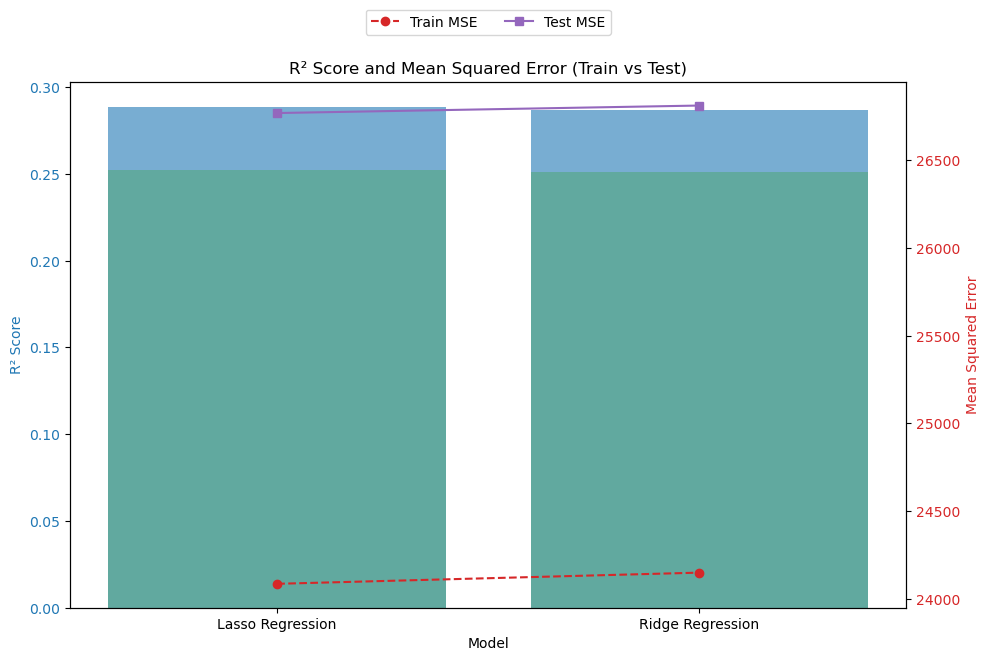

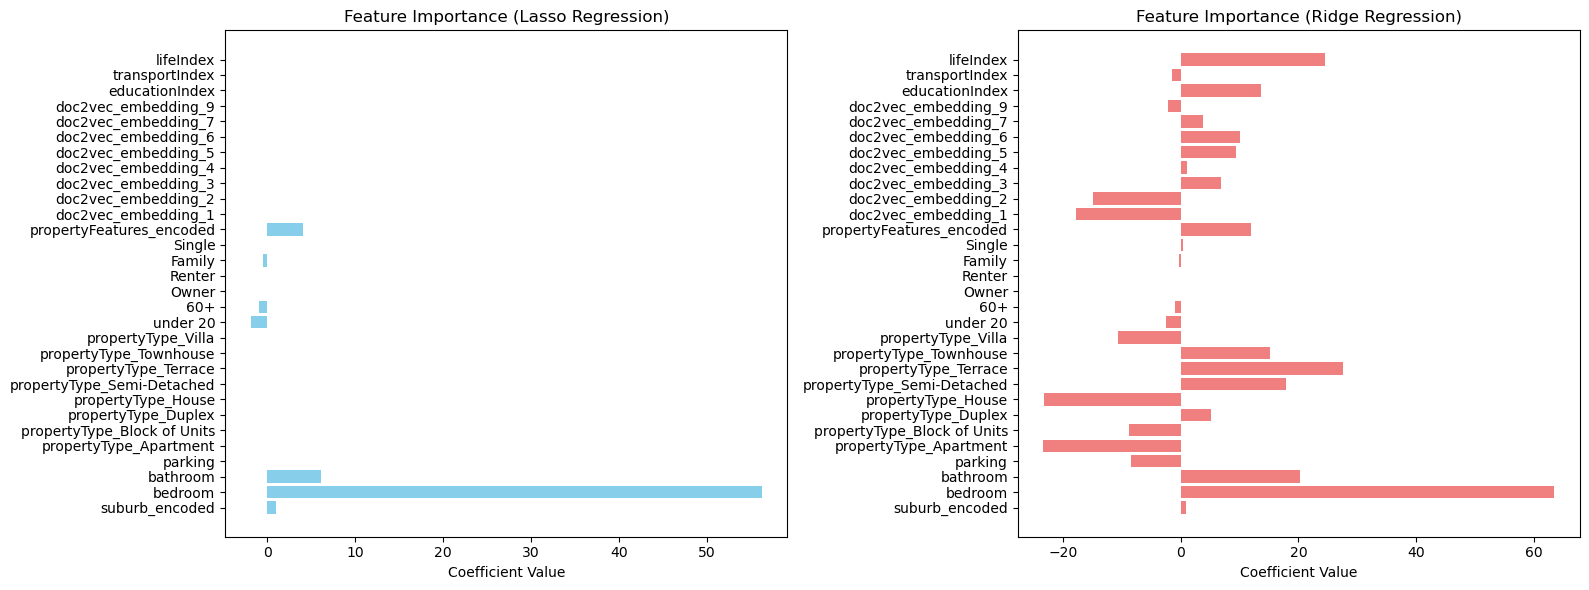

In [23]:
# Set up the models for Lasso and Ridge
models = [
    Lasso(),
    Ridge()
]

model_titles = [
    'Lasso Regression',
    'Ridge Regression'
]

# Initialize lists to store results
best_r2_scores_train = []
mean_squared_errors_train = []
best_r2_scores_test = []
mean_squared_errors_test = []
titles = []

# Perform GridSearchCV for each model on train data
for title, model in zip(model_titles, models):
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Standardizing features
        ('regressor', model)           # Lasso or Ridge model
    ])
    
    # Define the grid for hyperparameter tuning (Lasso and Ridge have alpha)
    param_grid = {'regressor__alpha': [0.1, 1, 10]}
    
    # Use GridSearchCV for cross-validation on train data
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")  # To suppress any warnings during fitting
        grid_search.fit(X_train, y_train)  # Use train data
    
    # Store results for the training set
    best_alpha = grid_search.best_params_['regressor__alpha']
    best_r2_train = grid_search.best_score_

    # Calculate cross-validated MSE for the training set
    mse_scorer = make_scorer(mean_squared_error)
    cv_mse_train = cross_val_score(grid_search.best_estimator_, X_train, y_train, 
                                    cv=5, scoring=mse_scorer).mean()

    best_r2_scores_train.append(best_r2_train)
    mean_squared_errors_train.append(cv_mse_train)

    # Test on the test set using the best estimator from GridSearchCV
    test_r2 = grid_search.best_estimator_.score(X_test, y_test)
    test_mse = mean_squared_error(y_test, grid_search.best_estimator_.predict(X_test))

    best_r2_scores_test.append(test_r2)
    mean_squared_errors_test.append(test_mse)
    titles.append(title)

    print(f"{title}: Best Alpha={best_alpha}, R² Score (Train)={best_r2_train:.4f}, MSE (Train)={cv_mse_train:.4f}")
    print(f"{title}: R² Score (Test)={test_r2:.4f}, MSE (Test)={test_mse:.4f}")

# Plot R² scores and MSE for both training and test sets together
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot R² scores on the train and test sets
color = 'tab:blue'
ax1.set_xlabel('Model')
ax1.set_ylabel('R² Score', color=color)
ax1.bar(titles, best_r2_scores_train, color=color, alpha=0.6, label='Train R²')
ax1.bar(titles, best_r2_scores_test, color='tab:green', alpha=0.3, label='Test R²')
ax1.tick_params(axis='y', labelcolor=color)

# Create a twin axis to plot MSE for both train and test sets
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Mean Squared Error', color=color)
ax2.plot(titles, mean_squared_errors_train, color='tab:red', marker='o', linestyle='--', label='Train MSE')
ax2.plot(titles, mean_squared_errors_test, color='tab:purple', marker='s', linestyle='-', label='Test MSE')
ax2.tick_params(axis='y', labelcolor=color)

# Finalize the plot
fig.tight_layout()
plt.title('R² Score and Mean Squared Error (Train vs Test)')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)
plt.show()

# Step 9: Plot Feature Importance for Lasso and Ridge Regression (side by side)
lasso_model = Lasso(alpha=best_alpha).fit(X_train, y_train)
ridge_model = Ridge(alpha=best_alpha).fit(X_train, y_train)

lasso_coefficients = lasso_model.coef_
ridge_coefficients = ridge_model.coef_

# Plot feature importances for both models
fig, (ax5, ax6) = plt.subplots(1, 2, figsize=(16, 6))

# Lasso feature importances
ax5.barh(X_train.columns, lasso_coefficients, color='skyblue')
ax5.set_title('Feature Importance (Lasso Regression)')
ax5.set_xlabel('Coefficient Value')

# Ridge feature importances
ax6.barh(X_train.columns, ridge_coefficients, color='lightcoral')
ax6.set_title('Feature Importance (Ridge Regression)')
ax6.set_xlabel('Coefficient Value')

plt.tight_layout()
plt.show()